In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy


In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)

dirname = '/home/jeon/MissingSat/database'

# LG = pklload(f"{dirname}/00_LocalGroup_fix.pickle")
LG = pklload(f"{dirname}/00_LocalGroup_final.pickle")
print(LG.keys())
print(LG[2].keys())
MASSs = pklload(f"{dirname}/01_mass_in_sub.pickle")
MASSs_rvir = pklload(f"{dirname}/01_mass_in_sub_rvir.pickle")

scores = pklload(f"{dirname}/befo231031/08_nh_scores.pickle")
dm_scores = pklload(f"{dirname}/befo231031/08_nh_dm_scores.pickle")

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 14, 17, 23, 24, 25, 26, 29, 35, 36, 37, 40, 46, 47, 52, 63, 64, 75, 84, 92, 107, 108, 121, 129, 207, 11])
dict_keys(['BGG', 'neighbor', 'sats', 'subs', 'real', 'box', 'parking', 'UDG'])


In [30]:
gals2 = pklload(f"{dirname}/befo231031/01_nh_ghmatch.pickle")


# Find omitted Subhalos

In [3]:
for key in LG.keys():
    if(not os.path.exists(f"./nh_take_dm_scores_host{key:04d}_new.pickle")): continue
    new_scores = pklload(f"./nh_take_dm_scores_host{key:04d}_new.pickle")
    BGG = LG[key]['BGG']
    subs = LG[key]['subs']
    real = LG[key]['real']; rtype = LG[key]['real'].dtype
    print(f"[{key:04d}]")
    for ikey in new_scores.keys():
        if(ikey in subs['id']): continue
        dm_scores['take'][key][ikey] = new_scores[ikey]
        isgood = np.median(new_scores[ikey]%1) > 0.25
        if(isgood):
            subs = np.hstack((subs, hals[ikey-1]))
            arr = np.zeros(1, dtype=rtype)[0]
            arr['hid'] = ikey; arr['gid'] = -1; arr['state'] = 'dink'
            real = np.hstack((real, arr))
    print(f" > Subs {len(LG[key]['subs'])} -> {len(subs)} & Real {len(LG[key]['real'])} -> {len(real)}")
    LG[key]['subs'] = subs
    LG[key]['real'] = real
pklsave(LG, f"{dirname}/00_LocalGroup_final.pickle", overwrite=True)


[0001]
 > Subs 113 -> 113 & Real 121 -> 121
[0002]
 > Subs 531 -> 531 & Real 549 -> 549
[0003]
 > Subs 71 -> 71 & Real 74 -> 74
[0004]
 > Subs 485 -> 485 & Real 536 -> 536
[0007]
 > Subs 91 -> 91 & Real 96 -> 96
[0008]
 > Subs 90 -> 90 & Real 100 -> 100
[0009]
 > Subs 117 -> 117 & Real 135 -> 135
[0010]
 > Subs 100 -> 100 & Real 101 -> 101
[0014]
 > Subs 396 -> 396 & Real 424 -> 424
[0017]
 > Subs 34 -> 34 & Real 34 -> 34
[0024]
 > Subs 58 -> 58 & Real 58 -> 58
[0025]
 > Subs 177 -> 177 & Real 209 -> 209
[0026]
 > Subs 40 -> 40 & Real 40 -> 40
[0029]
 > Subs 32 -> 32 & Real 32 -> 32
[0036]
 > Subs 292 -> 292 & Real 295 -> 295
[0040]
 > Subs 9 -> 9 & Real 9 -> 9
[0046]
 > Subs 109 -> 109 & Real 112 -> 112
[0052]
 > Subs 42 -> 42 & Real 42 -> 42
[0063]
 > Subs 21 -> 21 & Real 22 -> 22
[0064]
 > Subs 95 -> 95 & Real 101 -> 101
[0075]
 > Subs 26 -> 26 & Real 26 -> 26
[0084]
 > Subs 21 -> 21 & Real 21 -> 21
[0092]
 > Subs 44 -> 44 & Real 45 -> 45
[0107]
 > Subs 38 -> 38 & Real 39 -> 39
[012

# Reduce Box

In [4]:
for key in LG.keys():
    print(f"[{key:04d}]")
    BGG = LG[key]['BGG']
    subs = LG[key]['subs']
    sats = LG[key]['sats']

    x1s = np.hstack((subs['x']-subs['r'], sats['x']-sats['r']))
    x1 = min( BGG['x'] - 1.5*BGG['r200_code'], BGG['x'] - BGG['r'], np.min(x1s) )
    x2s = np.hstack((subs['x']+subs['r'], sats['x']+sats['r']))
    x2 = max( BGG['x'] + 1.5*BGG['r200_code'], BGG['x'] + BGG['r'], np.max(x2s) )
    y1s = np.hstack((subs['y']-subs['r'], sats['y']-sats['r']))
    y1 = min( BGG['y'] - 1.5*BGG['r200_code'], BGG['y'] - BGG['r'], np.min(y1s) )
    y2s = np.hstack((subs['y']+subs['r'], sats['y']+sats['r']))
    y2 = max( BGG['y'] + 1.5*BGG['r200_code'], BGG['y'] + BGG['r'], np.max(y2s) )
    z1s = np.hstack((subs['z']-subs['r'], sats['z']-sats['r']))
    z1 = min( BGG['z'] - 1.5*BGG['r200_code'], BGG['z'] - BGG['r'], np.min(z1s) )
    z2s = np.hstack((subs['z']+subs['r'], sats['z']+sats['r']))
    z2 = max( BGG['z'] + 1.5*BGG['r200_code'], BGG['z'] + BGG['r'], np.max(z2s) )

    dx = x2-x1; dy = y2-y1; dz = z2-z1
    xc = (x1+x2)/2; yc = (y1+y2)/2; zc = (z1+z2)/2
    x1 -= 0.05*dx; x2 += 0.05*dx
    y1 -= 0.05*dy; y2 += 0.05*dy
    z1 -= 0.05*dz; z2 += 0.05*dz
    newbox = np.array([[x1,x2],[y1,y2],[z1,z2]])
    oldbox = LG[key]['box']
    if(np.array_equal(newbox, oldbox)): continue
    print(f"{oldbox}\n ->\n{newbox}")

    LG[key]['box'] = newbox
    star = pklload(f"{dirname}/parts/nh_star_{key:04d}.pickle")
    indx = (star['x'] >= x1)&(star['x'] <= x2)
    indy = (star['y'] >= y1)&(star['y'] <= y2)
    indz = (star['z'] >= z1)&(star['z'] <= z2)
    star = star[indx&indy&indz]
    pklsave(star, f"{dirname}/parts/nh_star_{key:04d}.pickle", overwrite=True)
    dm = pklload(f"{dirname}/parts/nh_dm_{key:04d}.pickle")
    indx = (dm['x'] >= x1)&(dm['x'] <= x2)
    indy = (dm['y'] >= y1)&(dm['y'] <= y2)
    indz = (dm['z'] >= z1)&(dm['z'] <= z2)
    dm = dm[indx&indy&indz]
    pklsave(dm, f"{dirname}/parts/nh_dm_{key:04d}.pickle", overwrite=True)
    cell = pklload(f"{dirname}/parts/nh_cell_{key:04d}.pickle")
    indx = (cell['x'] >= x1)&(cell['x'] <= x2)
    indy = (cell['y'] >= y1)&(cell['y'] <= y2)
    indz = (cell['z'] >= z1)&(cell['z'] <= z2)
    cell = cell[indx&indy&indz]
    pklsave(cell, f"{dirname}/parts/nh_cell_{key:04d}.pickle", overwrite=True)
pklsave(LG, f"{dirname}/00_LocalGroup_final.pickle", overwrite=True)

    # fig,ax = fancy_axis(figsize=(6,6), dpi=150)
    # imread = plt.imread(f"/home/jeon/MissingSat/database/photo/00_LG_image/NH_{key:04d}_total.png")
    # ax.imshow(imread, extent=oldbox[:2].flatten())
    # for ihal in subs:
    #     cir = plt.Circle((ihal['x'], ihal['y']), ihal['r'], color='yellowgreen', fill=False, lw=0.3)
    #     ax.add_patch(cir)
    # rect = plt.Rectangle((newbox[0,0],newbox[1,0]), newbox[0,1]-newbox[0,0], newbox[1,1]-newbox[1,0], fill=False, color='r', linewidth=1)
    # ax.add_patch(rect)
    # cir = plt.Circle((BGG['x'], BGG['y']), max(1.5*BGG['r200_code'], BGG['r']), color='red', fill=False, lw=0.3)
    # ax.add_patch(cir)
    
    # plt.show()
    # plt.close()


[0001]
[0002]
[0003]
[0004]
[0007]
[0008]
[0009]
[0010]
[0014]
[0017]
[0023]
[0024]
[0025]
[0026]
[0029]
[0035]
[0036]
[0037]
[0040]
[0046]
[0047]
[0052]
[0063]
[0064]
[0075]
[0084]
[0092]
[0107]
[0108]
[0121]
[0129]
[0207]
[0011]


# Mass in sub

In [5]:
for key in LG.keys():
    if(not os.path.exists(f"./nh_take_dm_scores_host{key:04d}_new.pickle")): continue
    BGG = LG[key]['BGG']
    subs = LG[key]['subs']
    real = LG[key]['real']
    imass = MASSs[MASSs['host']==key]
    snap.box = LG[key]['box']
    print(f"[{key:04d}]")
    star = uri.Particle(pklload(f"{dirname}/parts/nh_star_{key:04d}.pickle"), snap)
    dm = uri.Particle(pklload(f"{dirname}/parts/nh_dm_{key:04d}.pickle"), snap)
    cell = uri.Cell(pklload(f"{dirname}/parts/nh_cell_{key:04d}.pickle"), snap)

    ids = np.zeros(len(subs), dtype=int)-1
    mstar = np.zeros(len(subs))
    mcell = np.zeros(len(subs))
    mcold = np.zeros(len(subs))
    mdm = np.zeros(len(subs))
    mstar_rvir = np.zeros(len(subs))
    mcell_rvir = np.zeros(len(subs))
    mcold_rvir = np.zeros(len(subs))
    mdm_rvir = np.zeros(len(subs))
    for i,sub in tqdm(enumerate(subs), total=len(subs)):
        if(sub['id'] in imass['sub']): continue
        ids[i] = sub['id']
        istar = cut_sphere(star, sub['x'],sub['y'],sub['z'],sub['r'])
        pklsave(istar.table, f"{dirname}/parts/insub/nh_star_{key:04d}_{sub['id']:07d}.pickle")
        if(len(istar)>0):
            mstar[i] = np.sum(istar['m','Msol'])
            istar = cut_sphere(istar, sub['x'],sub['y'],sub['z'],sub['rvir'])
            if(len(istar)>0): mstar_rvir[i] = np.sum(istar['m','Msol'])
        idm = cut_sphere(dm, sub['x'],sub['y'],sub['z'],sub['r'])
        pklsave(idm.table, f"{dirname}/parts/insub/nh_dm_{key:04d}_{sub['id']:07d}.pickle")
        if(len(idm)>0):
            mdm[i] = np.sum(idm['m','Msol'])
            idm = cut_sphere(idm, sub['x'],sub['y'],sub['z'],sub['rvir'])
            if(len(idm)>0): mdm_rvir[i] = np.sum(idm['m','Msol'])
        icell = cut_sphere(cell, sub['x'],sub['y'],sub['z'],sub['r'])
        pklsave(icell.table, f"{dirname}/parts/insub/nh_cell_{key:04d}_{sub['id']:07d}.pickle")
        icold = icell[icell['T','K'] < 2e4]
        if(len(icold)>0):
            mcold[i] = np.sum(icold['m','Msol'])
            icold = cut_sphere(icold, sub['x'],sub['y'],sub['z'],sub['rvir'])
            if(len(icold)>0): mcold_rvir[i] = np.sum(icold['m','Msol'])
        if(len(icell)>0):
            mcell[i] = np.sum(icell['m','Msol'])
            icell = cut_sphere(icell, sub['x'],sub['y'],sub['z'],sub['rvir'])
            if(len(icell)>0):
                mcell_rvir[i] = np.sum(icell['m','Msol'])
    mask = ids>0
    if(True in mask):
        ids = ids[mask]; host = np.full(len(ids), key, dtype=np.int32); dinks = np.full(len(ids), True, dtype=bool)
        mstar = mstar[mask]; mcell = mcell[mask]; mcold = mcold[mask]; mdm = mdm[mask]
        mstar_rvir = mstar_rvir[mask]; mcell_rvir = mcell_rvir[mask]; mcold_rvir = mcold_rvir[mask]; mdm_rvir = mdm_rvir[mask]
        where = mstar==0; mstar[where] += 1e3
        where = mcell==0; mcell[where] += 1e3
        where = mcold==0; mcold[where] += 1e3
        where = mdm==0; mdm[where] += 1e3
        where = mstar_rvir==0; mstar_rvir[where] += 1e3
        where = mcell_rvir==0; mcell_rvir[where] += 1e3
        where = mcold_rvir==0; mcold_rvir[where] += 1e3
        where = mdm_rvir==0; mdm_rvir[where] += 1e3
        arr = np.rec.fromarrays((host, ids,dinks, mdm, mstar, mcold, mcell), names=('host','sub','dink','mdm','mstar','mcold','mcell'))
        MASSs = np.hstack((MASSs, arr))
        arr = np.rec.fromarrays((host, ids,dinks, mdm_rvir, mstar_rvir, mcold_rvir, mcell_rvir), names=('host','sub','dink','mdm','mstar','mcold','mcell'))
        MASSs_rvir = np.hstack((MASSs_rvir, arr))
pklsave(MASSs, f"{dirname}/01_mass_in_sub.pickle", overwrite=True)
pklsave(MASSs_rvir, f"{dirname}/01_mass_in_sub_rvir.pickle", overwrite=True)
        

[0001]


100%|██████████| 113/113 [00:00<00:00, 51377.38it/s]


[0002]


100%|██████████| 531/531 [00:00<00:00, 52707.97it/s]


[0003]


100%|██████████| 71/71 [00:00<00:00, 46698.38it/s]


[0004]


100%|██████████| 485/485 [00:00<00:00, 46180.19it/s]


[0007]


100%|██████████| 91/91 [00:00<00:00, 48179.96it/s]


[0008]


100%|██████████| 90/90 [00:00<00:00, 47316.04it/s]


[0009]


100%|██████████| 117/117 [00:00<00:00, 48381.50it/s]


[0010]


100%|██████████| 100/100 [00:00<00:00, 47743.93it/s]


[0014]


100%|██████████| 396/396 [00:00<00:00, 44332.04it/s]


[0017]


100%|██████████| 34/34 [00:00<00:00, 38211.77it/s]


[0024]


100%|██████████| 58/58 [00:00<00:00, 45479.46it/s]


[0025]


100%|██████████| 177/177 [00:00<00:00, 47549.59it/s]


[0026]


100%|██████████| 40/40 [00:00<00:00, 38497.51it/s]


[0029]


100%|██████████| 32/32 [00:00<00:00, 39499.04it/s]


[0036]


100%|██████████| 292/292 [00:00<00:00, 44209.54it/s]


[0040]


100%|██████████| 9/9 [00:00<00:00, 23891.61it/s]


[0046]


100%|██████████| 109/109 [00:00<00:00, 48755.37it/s]


[0052]


100%|██████████| 42/42 [00:00<00:00, 42851.07it/s]


[0063]


100%|██████████| 21/21 [00:00<00:00, 35416.32it/s]


[0064]


100%|██████████| 95/95 [00:00<00:00, 48687.55it/s]


[0075]


100%|██████████| 26/26 [00:00<00:00, 37983.94it/s]


[0084]


100%|██████████| 21/21 [00:00<00:00, 34690.97it/s]


[0092]


100%|██████████| 44/44 [00:00<00:00, 43680.33it/s]


[0107]


100%|██████████| 38/38 [00:00<00:00, 48980.81it/s]


[0121]


100%|██████████| 26/26 [00:00<00:00, 37539.38it/s]


[0129]


100%|██████████| 32/32 [00:00<00:00, 40820.48it/s]


[0207]


100%|██████████| 9/9 [00:00<00:00, 26867.43it/s]


[0011]


100%|██████████| 37/37 [00:00<00:00, 38565.92it/s]


# Find satellite

In [6]:
def point_in_sphere(point, sphere, rname='r', factor=1):
    dist = np.sqrt( (point['x'] - sphere['x'])**2 + (point['y'] - sphere['y'])**2 + (point['z'] - sphere['z'])**2 )
    # print(dist, sphere[rname]*factor)
    return dist < sphere[rname]*factor

def sphere_in_sphere(inner, outer, r1='r',r2='r', factor=1):
    dist = np.sqrt( (inner['x'] - outer['x'])**2 + (inner['y'] - outer['y'])**2 + (inner['z'] - outer['z'])**2 )
    # print(dist+inner[r1], outer[r2])
    return (dist+inner[r1]) < outer[r2]

def sphere_touch_sphere(sph1, sph2, r1='r',r2='r', factor=1):
    dist = np.sqrt( (sph1['x'] - sph2['x'])**2 + (sph1['y'] - sph2['y'])**2 + (sph1['z'] - sph2['z'])**2 )
    # print(dist, sph1[r1]+sph2[r2])
    return dist < (sph1[r1]+sph2[r2])*factor


In [7]:
for key in LG.keys():
    BGG = LG[key]['BGG']
    sats = LG[key]['sats']
    subs = LG[key]['subs']
    real = LG[key]['real']
    igals = gals[~isin(gals['id'], sats['id'])]
    igals = igals[igals['id'] != BGG['id']]
    LG[key]['parking'] = None

    tmp = MASSs[MASSs['host']==key]
    tmp = tmp[tmp['dink']]
    fig, ax = plt.subplots(dpi=50)
    ax.scatter(sats['x'], sats['y'], color='g', s=1)
    for sat in sats:
        cir = plt.Circle((sat['x'], sat['y']), sat['r'], color='cyan', fill=False)
        ax.add_patch(cir)
    count = 0
    for itmp in tmp:
        if(itmp['mstar'] < 6e5): continue
        dink = subs[subs['id'] == itmp['sub']][0]
        insides2 = igals['r']<dink['r']
        insides = point_in_sphere(dink, igals, rname='r', factor=1) & insides2
        if(np.sum(insides)==0):
            insides = sphere_in_sphere(igals, dink, r2='rvir')
        if(np.sum(insides)==0):
            insides1 = sphere_touch_sphere(dink, igals, r1='rvir', factor=0.5)
            insides = insides1&insides2
        gcands = igals[insides]
        if(len(gcands)==0): continue
        elif(len(gcands)==1):
            gcand = gcands[0]
            where = np.where(real['hid'] == dink['id'])[0][0]
            real[where]['gid'] = gcand['id']; count+=1
            real[where]['state'] = 'pair'
        else:
            dists = distance(gcand, gcands)
            argmin = np.argmin(dists)
            gcand = gcands[argmin]
            where = np.where(real['hid'] == dink['id'])[0][0]
            real[where]['gid'] = gcand['id']; count+=1
            real[where]['state'] = 'pair'
        
        LG[key]['parking'] = gcand if(LG[key]['parking'] is None) else np.hstack((LG[key]['parking'], gcand))
        ax.scatter(dink['x'],dink['y'], color='k', s=4)
        cir = plt.Circle((dink['x'], dink['y']), dink['rvir'], color='k', fill=False)
        ax.add_patch(cir)
        ax.scatter(gcand['x'],gcand['y'], color='r', s=4)
        cir = plt.Circle((gcand['x'], gcand['y']), gcand['r'], color='r', fill=False)
        ax.plot([dink['x'], gcand['x']],[dink['y'], gcand['y']], color='k')
        ax.add_patch(cir)
    ax.set_aspect(1)
    ax.set_title(f"{key:04d}")
    if(count>0):
        print(f"[{key}] {count}/{len(tmp)} are matched")
        # plt.show()
        plt.close()
    else:
        plt.close()
pklsave(LG, f"{dirname}/00_LocalGroup_final.pickle", overwrite=True)

[1] 3/109 are matched
[2] 5/490 are matched
[3] 5/63 are matched
[4] 8/430 are matched
[7] 3/81 are matched
[8] 2/82 are matched
[9] 3/105 are matched
[10] 2/87 are matched
[14] 5/359 are matched
[17] 2/32 are matched
[24] 3/55 are matched
[25] 4/163 are matched
[29] 1/29 are matched
[36] 8/273 are matched
[40] 1/8 are matched
[46] 4/97 are matched
[52] 2/41 are matched
[75] 5/24 are matched
[84] 1/21 are matched
[92] 2/41 are matched
[107] 1/37 are matched
[129] 1/29 are matched


## UDG candidates

In [8]:
for key in LG.keys():
    BGG = LG[key]['BGG']
    sats = LG[key]['sats']
    subs = LG[key]['subs']
    real = LG[key]['real']
    igals = gals[~isin(gals['id'], sats['id'])]
    igals = igals[igals['id'] != BGG['id']]
    LG[key]['UDG'] = []

    tmp = MASSs[MASSs['host']==key]
    tmp = tmp[tmp['dink']]
    fig, ax = plt.subplots(dpi=50)
    ax.scatter(sats['x'], sats['y'], color='g', s=1)
    for sat in sats:
        cir = plt.Circle((sat['x'], sat['y']), sat['r'], color='cyan', fill=False)
        ax.add_patch(cir)
    count = 0
    for itmp in tmp:
        if(itmp['mstar'] < 6e5): continue
        dink = subs[subs['id'] == itmp['sub']][0]
        where = np.where(real['hid'] == dink['id'])[0][0]
        if(real[where]['gid']>0): continue
        insides1 = sphere_touch_sphere(dink, igals, r1='rvir', factor=0.75)
        insides2 = igals['r'] < 2*dink['r']
        insides = insides1&insides2
        gcands = igals[insides]
        if(len(gcands)==0):
            star = pklload(f"{dirname}/parts/insub/nh_star_{key:04d}_{dink['id']:07d}.pickle")
            if(len(star)>300):
                LG[key]['UDG'].append(dink['id'])
        else:
            print(f"[{key:04d}] ({dink['id']}) {len(gcands)} cands and logM*={np.log10(itmp['mstar'])}")
            count += 1
            cir = plt.Circle((dink['x'], dink['y']), dink['r'], color='grey', fill=False)
            ax.add_patch(cir)
            cir = plt.Circle((dink['x'], dink['y']), dink['rvir'], color='k', fill=False)
            ax.add_patch(cir)
            for gcand in gcands:
                cir = plt.Circle((gcand['x'], gcand['y']), gcand['r'], color='r', fill=False)
                ax.add_patch(cir)
                ax.plot([dink['x'], gcand['x']],[dink['y'], gcand['y']], color='k')
    ax.set_aspect(1)
    ax.set_title(f"{key:04d}")
    if(count>0):
        print(f"[{key}] {count}/{len(tmp)} are matched")
        # plt.show()
        plt.close()
    else:
        plt.close()
pklsave(LG, f"{dirname}/00_LocalGroup_final.pickle", overwrite=True)

[0064] (26098) 1 cands and logM*=7.833543446418819
[64] 1/91 are matched


# Calc VAD of new sats

new sats ID are saved in `parking` key

In [11]:
all_sats = None
parkings = None
for key in LG.keys():
    sats = LG[key]['sats']
    all_sats = sats if(all_sats is None) else np.hstack((all_sats, sats))
    parking = LG[key]['parking']
    if(parking is None): continue
    if(isinstance(parking, np.record)or(parking.shape==())):
        parking = np.array([parking])
        LG[key]['parking'] = parking
    parkings = parking if(parkings is None) else np.hstack((parkings, parking))
    assert not True in isin(sats['id'], parking['id'])

In [12]:
cols = [
    "Host", "Sat", "r50m", "r90m", "r50r", "r90r", 
    "SFR_mem", "u_mem", "g_mem", "r_mem", "i_mem", "z_mem", "metal_mem", "ager_mem", "t50_mem", "t90_mem"] 
category = ["r50m", "r90m", "r50r", "r90r", "rmax"]


for icate in category:
    cols = cols+[f"SFR_{icate}", f"u_{icate}", f"g_{icate}", f"r_{icate}", f"i_{icate}", f"z_{icate}", f"metal_{icate}", f"ager_{icate}", f"t50_{icate}", f"t90_{icate}", f"mgas_{icate}", f"mcold_{icate}", f"mdm_{icate}"]

In [13]:
newarr = np.zeros(len(parkings), dtype=sats.dtype)
print(newarr.shape)

(71,)


In [141]:
def calc_rhalf(gal, part, weights, ratio=0.5):
    dist = distance(gal, part)
    argsort = np.argsort(dist)
    sw = np.cumsum(weights[argsort])
    sw /= sw[-1]
    return dist[argsort][np.argmin(np.abs(sw-ratio))]

def calc_rhalf_sorted(sorted_dist, sorted_weights, ratio=0.5):
    sw = np.cumsum(sorted_weights)
    sw /= sw[-1]
    return sorted_dist[np.argmin(np.abs(sw-ratio))]

def calc_tform(part, weights, ratio=0.5):
    age = part['age','Gyr']
    argsort = np.argsort(age)
    sw = np.cumsum(weights[argsort])
    sw /= sw[-1]
    return age[argsort][np.argmin(np.abs(sw-ratio))]

In [18]:
cols = [
    "Host", "Sat", "r50m", "r90m", "r50r", "r90r", 
    "SFR_mem", "u_mem", "g_mem", "r_mem", "i_mem", "z_mem", "metal_mem", "ager_mem", "t50_mem", "t90_mem"] 
category = ["r50m", "r90m", "r50r", "r90r", "rmax"]

uri.timer.verbose=0
for icate in category:
    cols = cols+[f"SFR_{icate}", f"u_{icate}", f"g_{icate}", f"r_{icate}", f"i_{icate}", f"z_{icate}", f"metal_{icate}", f"ager_{icate}", f"t50_{icate}", f"t90_{icate}", f"mgas_{icate}", f"mcold_{icate}", f"mdm_{icate}"]
with open("./value_added.txt", "+w") as f:
    f.write("\t".join(cols)+"\n")
    for key in LG.keys():
        if(LG[key]['parking'] is None): continue
        parkings = LG[key]['parking']
        MWA = LG[key]['BGG']
        print(f"{MWA['id']:04d} Load data...")
        snap.clear()
        snap.box = LG[key]['box']
        cell = pklload(f"{dirname}/parts/nh_cell_{MWA['id']:04d}.pickle"); cell = uri.Cell(cell, snap)
        star = pklload(f"{dirname}/parts/nh_star_{MWA['id']:04d}.pickle"); star = uri.Particle(star, snap)
        print(f" > Nstar = {len(star)}")
        dm = pklload(f"{dirname}/parts/nh_dm_{MWA['id']:04d}.pickle"); dm = uri.Particle(dm, snap)


        for sat in tqdm(parkings, desc=f"Sats of {MWA['id']:04d}"):
            pid = uhmi.HaloMaker.read_member_part(snap, sat['id'], galaxy=True, simple=True, usefortran=True).flatten()
            ind = isin(np.abs(star['id']), pid)
            if(np.sum(ind) < len(pid)):
                print("Reset the box...")
                print(snap.box)
                print(sat['x']-sat['r'], sat['x']+sat['r'])
                print(sat['y']-sat['r'], sat['y']+sat['r'])
                print(sat['z']-sat['r'], sat['z']+sat['r'])
                snap.box = LG[key]['box']
                snap.get_part(nthread=32)
                istar = snap.part['star']
                idm = snap.part['dm']
                snap.get_cell(nthread=32)
                icell = snap.cell

                mem_star = istar[isin(np.abs(istar['id']), pid)]
            else:
                istar = star
                icell = cell
                idm = dm


                mem_star = star[ind]
            r50m = calc_rhalf(sat, mem_star, mem_star['m'], ratio=0.5)
            r90m = calc_rhalf(sat, mem_star, mem_star['m'], ratio=0.9)

            rband = measure_luminosity(mem_star, 'SDSS_r', model='cb07')
            r50r = calc_rhalf(sat, mem_star, rband, ratio=0.5)
            r90r = calc_rhalf(sat, mem_star, rband, ratio=0.9)
            # Use member particles
            ind = mem_star['age', 'Myr'] < 100
            SFR_mem = np.sum(mem_star['m', 'Msol'][ind]) / 1e8
            u_mem = measure_luminosity(mem_star, 'SDSS_u', model='cb07', total=True)
            g_mem = measure_luminosity(mem_star, 'SDSS_g', model='cb07', total=True)
            r_mem = measure_luminosity(mem_star, 'SDSS_r', model='cb07', total=True)
            i_mem = measure_luminosity(mem_star, 'SDSS_i', model='cb07', total=True)
            z_mem = measure_luminosity(mem_star, 'SDSS_z', model='cb07', total=True)
            metal_mem = np.sum(mem_star['metal'] * mem_star['m']) / np.sum(mem_star['m'])
            ager_mem = np.average(mem_star['age', 'Gyr'], weights=rband)
            t50_mem = calc_tform(mem_star, rband, ratio=0.5)
            t90_mem = calc_tform(mem_star, rband, ratio=0.9)
            write = [MWA['id'], sat['id'], r50m, r90m, r50r, r90r, SFR_mem, u_mem, g_mem, r_mem, i_mem, z_mem, metal_mem, ager_mem, t50_mem, t90_mem]

            # Use radial cut
            radiis = [r50m, r90m, r50r, r90r, sat['r']]
            for radii, rname in zip(radiis, category):
                cut_star, cutind = cut_sphere(istar, sat['x'], sat['y'], sat['z'], radii, return_index=True)
                rband = measure_luminosity(cut_star, 'SDSS_r', model='cb07')
                SFR_rad = np.sum(cut_star['m', 'Msol'][cut_star['age', 'Myr'] < 100]) / 1e8
                u_rad = measure_luminosity(cut_star, 'SDSS_u', model='cb07', total=True)
                g_rad = measure_luminosity(cut_star, 'SDSS_g', model='cb07', total=True)
                r_rad = measure_luminosity(cut_star, 'SDSS_r', model='cb07', total=True)
                i_rad = measure_luminosity(cut_star, 'SDSS_i', model='cb07', total=True)
                z_rad = measure_luminosity(cut_star, 'SDSS_z', model='cb07', total=True)
                metal_rad = np.sum(cut_star['metal'] * cut_star['m']) / np.sum(cut_star['m'])
                ager_rad = np.average(cut_star['age', 'Gyr'], weights=rband)
                t50_rad = calc_tform(cut_star, rband, ratio=0.5)
                t90_rad = calc_tform(cut_star, rband, ratio=0.9)
                cut_gas = cut_sphere(icell, sat['x'], sat['y'], sat['z'], radii)
                cut_dm = cut_sphere(idm, sat['x'], sat['y'], sat['z'], radii)
                mgas_rad = np.sum(cut_gas['m', 'Msol'])
                coldind = cut_gas['T', 'K'] < 1e4
                mcold_rad = np.sum(cut_gas['m', 'Msol'][coldind])
                mdm_rad = np.sum(cut_dm['m', 'Msol'])
                write = write + [SFR_rad, u_rad, g_rad, r_rad, i_rad, z_rad, metal_rad, ager_rad, t50_rad, t90_rad, mgas_rad, mcold_rad, mdm_rad]
            f.write("\t".join([str(w) for w in write])+"\n")
uri.timer.verbose=1

0001 Load data...
 > Nstar = 7898479


Sats of 0001: 100%|██████████| 3/3 [00:19<00:00,  6.55s/it]


0002 Load data...
 > Nstar = 37815414


Sats of 0002: 100%|██████████| 5/5 [02:11<00:00, 26.21s/it]


0003 Load data...
 > Nstar = 4209987


Sats of 0003: 100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


0004 Load data...
 > Nstar = 43912740


Sats of 0004: 100%|██████████| 8/8 [03:50<00:00, 28.84s/it]


0007 Load data...
 > Nstar = 8621474


Sats of 0007: 100%|██████████| 3/3 [00:18<00:00,  6.14s/it]


0008 Load data...
 > Nstar = 9809636


Sats of 0008: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it]


0009 Load data...
 > Nstar = 24388884


Sats of 0009: 100%|██████████| 3/3 [00:39<00:00, 13.12s/it]


0010 Load data...
 > Nstar = 10734135


Sats of 0010: 100%|██████████| 2/2 [00:16<00:00,  8.20s/it]


0014 Load data...
 > Nstar = 37548989


Sats of 0014: 100%|██████████| 5/5 [01:56<00:00, 23.23s/it]


0017 Load data...
 > Nstar = 1510186


Sats of 0017: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]


0024 Load data...
 > Nstar = 4161280


Sats of 0024: 100%|██████████| 3/3 [00:11<00:00,  3.84s/it]


0025 Load data...
 > Nstar = 14502035


Sats of 0025: 100%|██████████| 4/4 [00:44<00:00, 11.19s/it]


0029 Load data...
 > Nstar = 2217705


Sats of 0029: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


0036 Load data...
 > Nstar = 7796800


Sats of 0036: 100%|██████████| 8/8 [01:29<00:00, 11.21s/it]


0040 Load data...
 > Nstar = 1313955


Sats of 0040: 100%|██████████| 1/1 [00:07<00:00,  7.29s/it]


0046 Load data...
 > Nstar = 5513450


Sats of 0046: 100%|██████████| 4/4 [00:22<00:00,  5.59s/it]


0052 Load data...
 > Nstar = 1348616


Sats of 0052: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


0075 Load data...
 > Nstar = 1558921


Sats of 0075: 100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


0084 Load data...
 > Nstar = 1253339


Sats of 0084: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


0092 Load data...
 > Nstar = 2312629


Sats of 0092: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


0107 Load data...
 > Nstar = 1651375


Sats of 0107: 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


0129 Load data...
 > Nstar = 1999557


Sats of 0129: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


In [19]:
cols = [
    "Host", "Sat", "r50m", "r90m", "r50r", "r90r", 
    "SFR_mem", "u_mem", "g_mem", "r_mem", "i_mem", "z_mem", "metal_mem", "ager_mem", "t50_mem", "t90_mem"] 
category = ["r50m", "r90m", "r50r", "r90r", "rmax"]


for icate in category:
    cols = cols+[f"SFR_{icate}", f"u_{icate}", f"g_{icate}", f"r_{icate}", f"i_{icate}", f"z_{icate}", f"metal_{icate}", f"ager_{icate}", f"t50_{icate}", f"t90_{icate}", f"mgas_{icate}", f"mcold_{icate}", f"mdm_{icate}"]

dtype = [(col, np.float64) for col in cols]
print(len(dtype))
dtype[0] = ("Host", np.int32)
dtype[1] = ("Sat", np.int32)
dtype = np.dtype(dtype)

vad = np.genfromtxt("./value_added.txt", delimiter="\t", dtype=dtype, skip_header=1)
pklsave(vad, "./value_added.pickle", overwrite=True)

81


In [42]:
for key in LG.keys():
    if(key in vad['Host']):
        tmp = vad[vad['Host']==key]
        sats = LG[key]['sats']

        satdtype = sats.dtype
        newsats = np.empty(len(tmp), dtype=satdtype)
        for i,tvac in enumerate(tmp):
            assert tvac['Sat'] in LG[key]['real']['gid']
            assert tvac['Sat'] not in sats['id']
            where = np.where(LG[key]['real']['gid']==tvac['Sat'])[0][0]
            goodsat = gals[gals['id']==tvac['Sat']][0]
            assert gals2[goodsat['id']-1]['halo_id'] == LG[key]['real']['hid'][where]
            for iname in satdtype.names:
                if(iname in gals.dtype.names):
                    newsats[i][iname] = goodsat[iname]
                elif(iname in gals2.dtype.names):
                    newsats[i][iname] = gals2[goodsat['id']-1][iname]
                elif(iname in tvac.dtype.names):
                    newsats[i][iname] = tvac[iname]
        new_sats = np.hstack((sats, newsats))
        LG[key]['sats'] = new_sats
pklsave(LG, f"{dirname}/00_LocalGroup_final.pickle", overwrite=True)


# Calc VAD of UDG

sub ID who hosts UDG are saved in `UDG` key

In [51]:
sats.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('Host', '<i4'), ('r50m', '<f8'), ('r90m', '<f8'), ('r50r

In [60]:
for key in LG.keys():
    UDGs = LG[key]['UDG']
    if(len(UDGs)==0): continue
    print(f"[{key:04d}]")
    BGG = LG[key]['BGG']
    sats = LG[key]['sats']
    subs = LG[key]['subs']
    real = LG[key]['real']
    
    hosts_of_udgs = subs[isin(subs['id'], UDGs)]
    udg_cats = np.zeros(len(UDGs), dtype=sats.dtype)
    for i, host in tqdm( enumerate(hosts_of_udgs), total=len(hosts_of_udgs) ):
        where = np.where(real['hid'] == host['id'])[0][0]
        if(LG[key]['real'][where]['state'] != 'upair'):
            assert real[where]['state']=='dink'
            LG[key]['real'][where]['state'] = 'upair'
            LG[key]['real'][where]['gid'] = -host['id']


        snap.set_box_halo(host, 1, radius_name='r')
        star = pklload(f"{dirname}/parts/insub/nh_star_{key:04d}_{host['id']:07d}.pickle"); star = uri.Particle(star, snap)
        dm = pklload(f"{dirname}/parts/insub/nh_dm_{key:04d}_{host['id']:07d}.pickle"); dm = uri.Particle(dm, snap)
        cell = pklload(f"{dirname}/parts/insub/nh_cell_{key:04d}_{host['id']:07d}.pickle"); cell = uri.Cell(cell, snap)

        udg_cats[i]['nparts'] = len(star)
        udg_cats[i]['id'] = -host['id']
        # Copy the host properties
        names = ['timestep', 'aexp']
        for name in names:
            udg_cats[i][name] = host[name]
        udg_cats[i]['fcontam'] = host['mcontam']/host['m']
        # With prefix
        names = ['halo_id', 'halo_nparts', 'halo_level', 'halo_host', 'halo_hostsub', 'halo_x', 'halo_y', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_mvir', 'halo_rvir']
        for name in names:
            udg_cats[i][name] = host[name[5:]]
        # Default Info
        udg_cats[i]['m'] = np.sum(star['m', 'Msol'])
        udg_cats[i]['x'] = np.average(star['x'], weights=star['m'])
        udg_cats[i]['y'] = np.average(star['y'], weights=star['m'])
        udg_cats[i]['z'] = np.average(star['z'], weights=star['m'])
        udg_cats[i]['vx'] = np.average(star['vx','km/s'], weights=star['m'])
        udg_cats[i]['vy'] = np.average(star['vy','km/s'], weights=star['m'])
        udg_cats[i]['vz'] = np.average(star['vz','km/s'], weights=star['m'])
        udg_cats[i]['dist'] = distance(udg_cats[i], host)
        # Calculate the angular momentum
        dx = star['x'] - udg_cats[i]['x']; dx /= snap.unit['Mpc']
        dy = star['y'] - udg_cats[i]['y']; dy /= snap.unit['Mpc']
        dz = star['z'] - udg_cats[i]['z']; dz /= snap.unit['Mpc']
        dpx = (star['vx','km/s'] - udg_cats[i]['vx'])*star['m','Msol']
        dpy = (star['vy','km/s'] - udg_cats[i]['vy'])*star['m','Msol']
        dpz = (star['vz','km/s'] - udg_cats[i]['vz'])*star['m','Msol']
        udg_cats[i]['Lx'] = np.sum(dpy*dz - dpz*dy)/1e11 # in 10**11 Msun * km/s * Mpc
        udg_cats[i]['Ly'] = np.sum(dpz*dx - dpx*dz)/1e11
        udg_cats[i]['Lz'] = np.sum(dpx*dy - dpy*dx)/1e11
        udg_cats[i]['r'] = np.max(np.sqrt(dx**2 + dy**2 + dz**2)) * snap.unit['Mpc']
        # Value Added
        udg_cats[i]['Host'] = host['id']
        udg_cats[i]['r50m'] = calc_rhalf(udg_cats[i], star, star['m'], ratio=0.5)
        udg_cats[i]['r90m'] = calc_rhalf(udg_cats[i], star, star['m'], ratio=0.9)

        rband = measure_luminosity(star, 'SDSS_r', model='cb07')
        udg_cats[i]['r50r'] = calc_rhalf(udg_cats[i], star, rband, ratio=0.5)
        udg_cats[i]['r90r'] = calc_rhalf(udg_cats[i], star, rband, ratio=0.9)
        # Use member particles
        ind = star['age', 'Myr'] < 100
        udg_cats[i]['SFR_mem'] = np.sum(star['m', 'Msol'][ind]) / 1e8
        udg_cats[i]['u_mem'] = measure_luminosity(star, 'SDSS_u', model='cb07', total=True)
        udg_cats[i]['g_mem'] = measure_luminosity(star, 'SDSS_g', model='cb07', total=True)
        udg_cats[i]['r_mem'] = measure_luminosity(star, 'SDSS_r', model='cb07', total=True)
        udg_cats[i]['i_mem'] = measure_luminosity(star, 'SDSS_i', model='cb07', total=True)
        udg_cats[i]['z_mem'] = measure_luminosity(star, 'SDSS_z', model='cb07', total=True)
        udg_cats[i]['metal_mem'] = np.sum(star['metal'] * star['m']) / np.sum(star['m'])
        udg_cats[i]['ager_mem'] = np.average(star['age', 'Gyr'], weights=rband)
        udg_cats[i]['t50_mem'] = calc_tform(star, rband, ratio=0.5)
        udg_cats[i]['t90_mem'] = calc_tform(star, rband, ratio=0.9)
        radiis = [udg_cats[i]['r50m'], udg_cats[i]['r90m'], udg_cats[i]['r50r'], udg_cats[i]['r90r'], udg_cats[i]['r']]
        for radii, rname in zip(radiis, category):
            cut_star, cutind = cut_sphere(star, udg_cats[i]['x'], udg_cats[i]['y'], udg_cats[i]['z'], radii, return_index=True)
            rband = measure_luminosity(cut_star, 'SDSS_r', model='cb07')
            udg_cats[i][f'SFR_{rname}'] = np.sum(cut_star['m', 'Msol'][cut_star['age', 'Myr'] < 100]) / 1e8
            udg_cats[i][f'u_{rname}'] = measure_luminosity(cut_star, 'SDSS_u', model='cb07', total=True)
            udg_cats[i][f'g_{rname}'] = measure_luminosity(cut_star, 'SDSS_g', model='cb07', total=True)
            udg_cats[i][f'r_{rname}'] = measure_luminosity(cut_star, 'SDSS_r', model='cb07', total=True)
            udg_cats[i][f'i_{rname}'] = measure_luminosity(cut_star, 'SDSS_i', model='cb07', total=True)
            udg_cats[i][f'z_{rname}'] = measure_luminosity(cut_star, 'SDSS_z', model='cb07', total=True)
            udg_cats[i][f'metal_{rname}'] = np.sum(cut_star['metal'] * cut_star['m']) / np.sum(cut_star['m'])
            udg_cats[i][f'ager_{rname}'] = np.average(cut_star['age', 'Gyr'], weights=rband)
            udg_cats[i][f't50_{rname}'] = calc_tform(cut_star, rband, ratio=0.5)
            udg_cats[i][f't90_{rname}'] = calc_tform(cut_star, rband, ratio=0.9)
            cut_gas = cut_sphere(icell, udg_cats[i]['x'], udg_cats[i]['y'], udg_cats[i]['z'], radii)
            cut_dm = cut_sphere(idm, udg_cats[i]['x'], udg_cats[i]['y'], udg_cats[i]['z'], radii)
            udg_cats[i][f'mgas_{rname}'] = np.sum(cut_gas['m', 'Msol'])
            coldind = cut_gas['T', 'K'] < 1e4
            udg_cats[i][f'mcold_{rname}'] = np.sum(cut_gas['m', 'Msol'][coldind])
            udg_cats[i][f'mdm_{rname}'] = np.sum(cut_dm['m', 'Msol'])
        LG[key]['sats'] = np.hstack((sats, udg_cats))
pklsave(LG, f"{dirname}/00_LocalGroup_final.pickle", overwrite=True)

[0001]


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:17<00:00,  2.22s/it]


[0002]


100%|██████████| 131/131 [05:06<00:00,  2.34s/it]


[0003]


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


[0004]


100%|██████████| 116/116 [03:59<00:00,  2.07s/it]


[0007]


100%|██████████| 11/11 [00:29<00:00,  2.70s/it]


[0008]


100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


[0009]


100%|██████████| 22/22 [00:52<00:00,  2.39s/it]


[0010]


100%|██████████| 9/9 [00:22<00:00,  2.54s/it]


[0014]


100%|██████████| 69/69 [02:49<00:00,  2.45s/it]


[0023]


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


[0024]


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


[0025]


100%|██████████| 19/19 [00:46<00:00,  2.45s/it]


[0029]


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


[0036]


100%|██████████| 19/19 [00:45<00:00,  2.42s/it]


[0063]


100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


[0064]


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


[0084]


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


[0092]


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


[0107]


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


[0121]


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


[0129]


100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


# Add DM properties

In [ ]:
# calc_rhalf_sorted(sorted_dist, sorted_weights)

In [144]:
dtype2 = [
    ("r10_mem", np.float64), ("r50_mem", np.float64), ("r90_mem", np.float64),
    ("r10_vir", np.float64), ("r50_vir", np.float64), ("r90_vir", np.float64),
    ("r10_max", np.float64), ("r50_max", np.float64), ("r90_max", np.float64),
    ]
uri.timer.verbose=0
for key in LG.keys():
    print(f"[{key:04d}]")
    BGG = LG[key]['BGG']
    subs = LG[key]['subs']
    dtype1 = subs.dtype
    dtype = np.dtype(dtype1.descr + dtype2)
    newsubs = np.zeros(len(subs), dtype=dtype)
    for iname in dtype1.names:
        newsubs[iname] = subs[iname]
    for i,sub in tqdm( enumerate(subs), total=len(subs) ):
        alldm = pklload(f"{dirname}/parts/insub/nh_dm_{key:04d}_{sub['id']:07d}.pickle")
        alldm = uri.Particle(alldm,snap)
        alldist = distance(sub, alldm); argsort = np.argsort(alldist)
        alldist = alldist[argsort]; allmass = alldm['m'][argsort]
        memdm = uhmi.HaloMaker.read_member_part(snap, sub['id'], galaxy=False, target_fields=['x','y','z','m'])
        memdist = distance(sub, memdm); argsort = np.argsort(memdist)
        memdist = memdist[argsort]; memmass = memdm['m'][argsort]

        newsubs[i]['r10_mem'] = calc_rhalf_sorted(memdist, memmass, ratio=0.1)
        newsubs[i]['r50_mem'] = calc_rhalf_sorted(memdist, memmass, ratio=0.5)
        newsubs[i]['r90_mem'] = calc_rhalf_sorted(memdist, memmass, ratio=0.9)
        newsubs[i]['r10_max'] = calc_rhalf_sorted(alldist, allmass, ratio=0.1)
        newsubs[i]['r50_max'] = calc_rhalf_sorted(alldist, allmass, ratio=0.5)
        newsubs[i]['r90_max'] = calc_rhalf_sorted(alldist, allmass, ratio=0.9)
        virdm, ind = cut_sphere(alldm, sub['x'], sub['y'], sub['z'], sub['rvir'], return_index=True)
        alldist = alldist[ind]; allmass = allmass[ind]
        newsubs[i]['r10_vir'] = calc_rhalf_sorted(alldist, allmass, ratio=0.1)
        newsubs[i]['r50_vir'] = calc_rhalf_sorted(alldist, allmass, ratio=0.5)
        newsubs[i]['r90_vir'] = calc_rhalf_sorted(alldist, allmass, ratio=0.9)
    LG[key]['subs'] = newsubs
uri.timer.verbose=1
pklsave(LG, f"{dirname}/00_LocalGroup_final.pickle", overwrite=True)

[0001]


100%|██████████| 113/113 [00:00<00:00, 312.95it/s]


[0002]


100%|██████████| 531/531 [00:02<00:00, 256.88it/s]


[0003]


100%|██████████| 71/71 [00:00<00:00, 167.90it/s]


[0004]


100%|██████████| 485/485 [00:03<00:00, 151.51it/s]


[0007]


100%|██████████| 91/91 [00:00<00:00, 159.71it/s]


[0008]


100%|██████████| 90/90 [00:00<00:00, 96.17it/s] 


[0009]


100%|██████████| 117/117 [00:00<00:00, 188.58it/s]


[0010]


100%|██████████| 100/100 [00:00<00:00, 160.00it/s]


[0014]


100%|██████████| 396/396 [00:02<00:00, 158.16it/s]


[0017]


100%|██████████| 34/34 [00:00<00:00, 146.46it/s]


[0023]


100%|██████████| 35/35 [00:00<00:00, 162.20it/s]


[0024]


100%|██████████| 58/58 [00:00<00:00, 84.93it/s] 


[0025]


100%|██████████| 177/177 [00:00<00:00, 205.99it/s]


[0026]


100%|██████████| 40/40 [00:00<00:00, 214.11it/s]


[0029]


100%|██████████| 32/32 [00:00<00:00, 217.90it/s]


[0035]


100%|██████████| 12/12 [00:00<00:00, 355.66it/s]


[0036]


100%|██████████| 292/292 [00:01<00:00, 151.93it/s]


[0037]


100%|██████████| 11/11 [00:00<00:00, 119.65it/s]


[0040]


100%|██████████| 9/9 [00:00<00:00, 219.35it/s]


[0046]


100%|██████████| 109/109 [00:01<00:00, 83.63it/s]


[0047]


100%|██████████| 8/8 [00:00<00:00, 128.13it/s]


[0052]


100%|██████████| 42/42 [00:00<00:00, 177.65it/s]


[0063]


100%|██████████| 21/21 [00:00<00:00, 158.78it/s]


[0064]


100%|██████████| 95/95 [00:00<00:00, 224.82it/s]


[0075]


100%|██████████| 26/26 [00:00<00:00, 85.90it/s]


[0084]


100%|██████████| 21/21 [00:00<00:00, 308.80it/s]


[0092]


100%|██████████| 44/44 [00:00<00:00, 304.77it/s]


[0107]


100%|██████████| 38/38 [00:00<00:00, 314.94it/s]


[0108]


100%|██████████| 14/14 [00:00<00:00, 188.53it/s]


[0121]


100%|██████████| 26/26 [00:00<00:00, 279.37it/s]


[0129]


100%|██████████| 32/32 [00:00<00:00, 261.94it/s]


[0207]


100%|██████████| 9/9 [00:00<00:00, 330.58it/s]


[0011]


100%|██████████| 37/37 [00:00<00:00, 210.98it/s]


---

# Density profile

In [121]:
def denprop(cen, parts, nbin=100):
    global snap
    # rbins = np.logspace(-2, 0.3, nbin+1)#np.linspace(0, 2, nbin+1)
    rbins = np.logspace(-0.3, np.log10(20), nbin+1) # kpc
    mbins = np.zeros(nbin)
    re = calc_rhalf(cen, parts, parts['m'], ratio=0.5)
    dist = distance(cen, parts)/snap.unit['kpc']#/re
    for i in range(nbin):
        ind = (dist>=rbins[i])&(dist<rbins[i+1])
        mbins[i] = np.sum(parts['m','Msol'][ind])
    vols = (4/3)*np.pi*(rbins[1:]**3 - rbins[:-1]**3)
    dens = mbins/vols
    return rbins, dens, mbins
    # vels = np.sqrt((cen['vx']-parts['vx','km/s'])**2 + (cen['vy']-parts['vy','km/s'])**2 + (cen['vz']-tmp['vz','km/s'])**2) / cen['sigma']



In [61]:
for key in LG.keys():
    BGG = LG[key]['BGG']
    subs = LG[key]['subs']
    for sub in subs:
        break
        idm = pklload(f"{dirname}/parts/insub/nh_dm_{key:04d}_{sub['id']:07d}.pickle")
        if(len(idm)==0): continue


In [125]:
ref = time.time()
sub = np.random.choice(subs)
idm = pklload(f"{dirname}/parts/insub/nh_dm_{key:04d}_{sub['id']:07d}.pickle")
idm = uri.Particle(idm,snap)
time.time()-ref

0.007086753845214844

In [137]:
def single(logr, const, gamma):
    # r = 10**logr
    return gamma * logr + const

def NFW(r_kpc, rs_kpc, rho0_Msunkpc3):
    x = r_kpc/rs_kpc
    return np.log10(rho0_Msunkpc3 / (x*(1+x)**2))

def chisq(obs, exp, weight, ddof=0):
    ssres = np.sum( (obs-exp)**2 * weight) / np.sum(weight)
    mean = np.mean(obs)
    sstot = np.sum( (obs-mean)**2 * weight) / np.sum(weight)
    return 1 - ssres/sstot

In [134]:
subs.shape

(37,)

In [135]:
ref = time.time()
sub = np.random.choice(subs)
tmp = uhmi.HaloMaker.read_member_part(snap, sub['id'], galaxy=False)
time.time()-ref

0.004390716552734375

0.9441931096833528


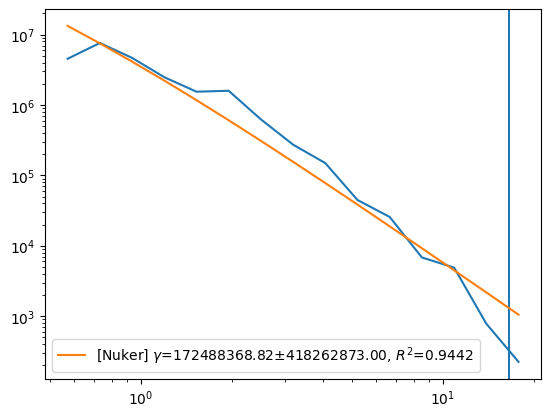

In [139]:
from scipy.optimize import curve_fit
x,y,m = denprop(sub, tmp, nbin=15); x = (x[1:]+x[:-1])/2
ws = 1/np.sqrt(m)
plt.plot(x,y)
plt.axvline(re/snap.unit['kpc'])
ind = y>0
popt,pcov = curve_fit(
    NFW, x[ind], np.log10(y[ind]),
    method='trf'
)
# popt, pcov = curve_fit(
#     Nuker, np.log10(x[ind]), np.log10(y[ind]), 
#     sigma=ws[ind],
#     p0=[1, -2], bounds=([-np.inf, -3.5], [np.inf, 0.5]), 
#     maxfev=5000, method='trf')
# chi = chisq(Nuker(np.log10(x[ind]), *popt), np.log10(y[ind]), ws[ind], ddof=2)
# plt.plot(x, 10**Nuker(np.log10(x), *popt), label=fr"[Nuker] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}")
chi = chisq( NFW(x[ind], *popt), np.log10(y[ind]), ws[ind], ddof=2 )
plt.plot(x, 10**NFW(x, *popt), label=fr"[Nuker] $\gamma$={popt[-1]:.2f}$\pm${np.sqrt(np.diag(pcov))[-1]:.2f}, $R^2$={chi:.4f}")

print(chi)

plt.yscale('log')
plt.xscale('log')
plt.legend()

# Draw Phase Space